In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import itertools
import time
import torch
import pylab as plt
# %matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

import memory_old as mem   
from feedforward_old import Feedforward

## Helper Functions

In [2]:
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

In [3]:
class DiscreteActionWrapper(gym.ActionWrapper):
    def __init__(self, env: gym.Env, bins = 5):
        """A wrapper for converting a 1D continuous actions into discrete ones.
        Args:
            env: The environment to apply the wrapper
            bins: number of discrete actions
        """
        assert isinstance(env.action_space, spaces.Box)
        super().__init__(env)
        self.bins = bins
        self.orig_action_space = env.action_space
        self.action_space = spaces.Discrete(self.bins)

    def action(self, action):
        """ discrete actions from low to high in 'bins'
        Args:
            action: The discrete action
        Returns:
            continuous action
        """
        return self.orig_action_space.low + action/(self.bins-1.0)*(self.orig_action_space.high-self.orig_action_space.low)  

# DQN and RND

In [4]:
class QFunction(Feedforward):
    def __init__(self, observation_dim, action_dim, hidden_sizes=[100,100], 
                 learning_rate = 0.0002):
        super().__init__(input_size=observation_dim, hidden_sizes=hidden_sizes, 
                         output_size=action_dim)
        self.optimizer=torch.optim.Adam(self.parameters(), 
                                        lr=learning_rate, 
                                        eps=0.000001)
        self.loss = torch.nn.SmoothL1Loss() # MSELoss()
    
    def fit(self, observations, actions, targets):
        self.train() # put model in training mode
        self.optimizer.zero_grad()
        # Forward pass
        acts = torch.from_numpy(actions)
        pred = self.Q_value(torch.from_numpy(observations).float(), acts)
        # Compute Loss
        loss = self.loss(pred, torch.from_numpy(targets).float())
        
        # Backward pass
        loss.backward()
        self.optimizer.step()
        return loss.item()
    
    def Q_value(self, observations, actions):
        return self.forward(observations).gather(1, actions[:,None])        
    
    def maxQ(self, observations):
        return np.max(self.predict(observations), axis=-1, keepdims=True)
        
    def greedyAction(self, observations):
        return np.argmax(self.predict(observations), axis=-1)
        

class RND():
    def __init__(self, input_dim, output_dim, hidden_dim=[100,100],
                 learning_rate = 0.0002):
        self.target = Feedforward(input_size = input_dim, hidden_sizes=hidden_dim, 
                                  output_size = output_dim)
        self.predictor = Feedforward(input_size = input_dim, hidden_sizes=hidden_dim, 
                                  output_size = output_dim)
        self.optimizer=torch.optim.Adam(self.predictor.parameters(), 
                                        lr=learning_rate, 
                                        eps=0.000001)
        self.loss = torch.nn.MSELoss()

    def intrinsic_reward(self, observations):
        output_target = self.target(observations).detach()
        output_prediction = self.predictor(observations)
        reward = self.loss(output_target, output_prediction)
        return reward

    def update_pred(self, reward):
        reward.backward()
        self.optimizer.step()
        

In [94]:
class DQNAgent(object):
    """
    Agent implementing Q-learning with NN function approximation.    
    """
    def __init__(self, observation_space, action_space, **userconfig):
        
        if not isinstance(observation_space, spaces.box.Box):
            raise UnsupportedSpace('Observation space {} incompatible ' \
                                   'with {}. (Require: Box)'.format(observation_space, self))
        if not isinstance(action_space, spaces.discrete.Discrete):
            raise UnsupportedSpace('Action space {} incompatible with {}.' \
                                   ' (Reqire Discrete.)'.format(action_space, self))
        
        self._observation_space = observation_space
        self._action_space = action_space
        self._action_n = action_space.n
        self._config = {
            "eps": 1.0,            # Epsilon in epsilon greedy policies                        
            "eps_decay": 0.98,     # Epsilon decay rate
            "eps_min": 0.001,       # Minimum epsilon
            "discount": 0.95,
            "buffer_size": int(1e5),
            "batch_size": 128,
            "learning_rate": 0.0002,
            "update_target_every": 20,
            "use_target_net":True
        }
        self._config.update(userconfig)        
        self._eps = self._config['eps']
        
        self.buffer = mem.Memory(max_size=self._config["buffer_size"])
                
        # Q Network
        self.Q = QFunction(observation_dim=self._observation_space.shape[0], 
                           action_dim=self._action_n,
                           learning_rate = self._config["learning_rate"])
        # Q Network
        self.Q_target = QFunction(observation_dim=self._observation_space.shape[0], 
                                  action_dim=self._action_n,
                                  learning_rate = 0)
        self._update_target_net()
        self.train_iter = 0
            
    def _update_target_net(self):        
        self.Q_target.load_state_dict(self.Q.state_dict())

    def act(self, observation, eps=None):
        if eps is None:
            eps = self._eps
        # epsilon greedy
        if np.random.random() > eps:
            action = self.Q.greedyAction(observation)
        else: 
            action = self._action_space.sample()        
        return action
    
    def store_transition(self, transition):
        self.buffer.add_transition(transition)
            
    def train(self, iter_fit=32):
        losses = []
        self.train_iter+=1
        if self._config["use_target_net"] and self.train_iter % self._config["update_target_every"] == 0:
            self._update_target_net()                
        for i in range(iter_fit):

            # sample from the replay buffer
            data=self.buffer.sample(batch=self._config['batch_size'])
            s = np.stack(data[:,0]) # s_t
            a = np.stack(data[:,1]) # a_t
            rew = np.stack(data[:,2])[:,None] # rew  (batchsize,1)
            s_prime = np.stack(data[:,3]) # s_t+1
            done = np.stack(data[:,4])[:,None] # done signal  (batchsize,1)
            
            if self._config["use_target_net"]:
                v_prime = self.Q_target.maxQ(s_prime)
            else:
                v_prime = self.Q.maxQ(s_prime)
            # target
            gamma=self._config['discount']                                                
            td_target = rew + gamma * (1.0-done) * v_prime
            
            # optimize the lsq objective
            fit_loss = self.Q.fit(s, a, td_target)
            
            losses.append(fit_loss)
                
        return losses

In [31]:
# dqn and rnd agent
class DQNRNDAgent(object):
    """
    Agent implementing Q-learning with NN function approximation.    
    """
    def __init__(self, observation_space, action_space, **userconfig):
        
        if not isinstance(observation_space, spaces.box.Box):
            raise UnsupportedSpace('Observation space {} incompatible ' \
                                   'with {}. (Require: Box)'.format(observation_space, self))
        if not isinstance(action_space, spaces.discrete.Discrete):
            raise UnsupportedSpace('Action space {} incompatible with {}.' \
                                   ' (Reqire Discrete.)'.format(action_space, self))
        
        self._observation_space = observation_space
        self._action_space = action_space
        self._action_n = action_space.n
        self._config = {
            "eps": 0.2,            # Epsilon in epsilon greedy policies 
            "eps_decay": 0.98,     # Epsilon decay rate
            "eps_min": 0.001,       # Minimum epsilon                       
            "discount": 0.95,
            "buffer_size": int(1e5),
            "batch_size": 128,
            "learning_rate": 0.0002,
            "learning_rate_rnd": 0.0001,
            "update_target_every": 20,
            "use_target_net":True
        }
        self._config.update(userconfig)        
        self._eps = self._config['eps']
        
        self.buffer = mem.Memory(max_size=self._config["buffer_size"])

        # RND
        self.rnd = RND(input_dim=self._observation_space.shape[0], 
                       output_dim=self._action_n,
                       learning_rate = self._config["learning_rate_rnd"])
                
        # Q Network
        self.Q = QFunction(observation_dim=self._observation_space.shape[0], 
                           action_dim=self._action_n,
                           learning_rate = self._config["learning_rate"])
        # Q Network
        self.Q_target = QFunction(observation_dim=self._observation_space.shape[0], 
                                  action_dim=self._action_n,
                                  learning_rate = 0)
        self._update_target_net()
        self.train_iter = 0
            
    def _update_target_net(self):        
        self.Q_target.load_state_dict(self.Q.state_dict())

    def act(self, observation, eps=None):
        if eps is None:
            eps = self._eps
        # epsilon greedy
        if np.random.random() > eps:
            action = self.Q.greedyAction(observation)
        else: 
            action = self._action_space.sample()        
        return action
    
    def store_transition(self, transition):
        self.buffer.add_transition(transition)
            
    def train(self, iter_fit=32):
        losses = []
        self.train_iter+=1
        if self._config["use_target_net"] and self.train_iter % self._config["update_target_every"] == 0:
            self._update_target_net()                
        for i in range(iter_fit):

            # sample from the replay buffer
            data=self.buffer.sample(batch=self._config['batch_size'])
            s = np.stack(data[:,0]) # s_t
            a = np.stack(data[:,1]) # a_t
            rew = np.stack(data[:,2])[:,None] # rew  (batchsize,1)
            s_prime = np.stack(data[:,3]) # s_t+1
            done = np.stack(data[:,4])[:,None] # done signal  (batchsize,1)

            rew_i = self.rnd.intrinsic_reward(torch.from_numpy(s))
            self.rnd.update_pred(rew_i)  # update predictor      
            
            if self._config["use_target_net"]:
                v_prime = self.Q_target.maxQ(s_prime)
            else:
                v_prime = self.Q.maxQ(s_prime)
            # target
            gamma=self._config['discount']                                                
            td_target = rew + gamma * (1.0-done) * v_prime
            
            # optimize the lsq objective
            fit_loss = self.Q.fit(s, a, td_target)
            
            losses.append(fit_loss)
                
        return losses

## Test in Env

In [95]:
#env_name = 'Pendulum-v1'
env_name = 'CartPole-v0'

env = gym.make(env_name)
if isinstance(env.action_space, spaces.Box):
    env = DiscreteActionWrapper(env,5)

ac_space = env.action_space
o_space = env.observation_space
print(ac_space)
print(o_space)
print(list(zip(env.observation_space.low, env.observation_space.high)))

Discrete(2)
Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
[(np.float32(-4.8), np.float32(4.8)), (np.float32(-inf), np.float32(inf)), (np.float32(-0.41887903), np.float32(0.41887903)), (np.float32(-inf), np.float32(inf))]


/Users/schebolu/work_study/coursework/RL_project/.venv/lib/python3.11/site-packages/gymnasium/envs/registration.py:517: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


### No RND

In [162]:
use_target = True
target_update = 10
q_agent = DQNAgent(o_space, ac_space, discount=0.95, eps=0.2,
                   use_target_net=use_target, update_target_every= target_update)

In [163]:
ob,_info = env.reset()
q_agent.Q.predict(ob)

array([ 0.04335109, -0.04976564], dtype=float32)

Running some episodes

In [164]:
stats = []
losses = []

In [165]:
max_episodes=400
max_steps=500 
# total_reward = 0
for i in range(max_episodes):
    # print("Starting a new episode")    
    total_reward = 0
    ob, _info = env.reset()
    for t in range(max_steps):
        done = False        
        a = q_agent.act(ob)
        (ob_new, reward, done, trunc, _info) = env.step(a)
        total_reward+= reward
        q_agent.store_transition((ob, a, reward, ob_new, done))            
        ob=ob_new        
        if done: break    
    losses.extend(q_agent.train(32))
    stats.append([i,total_reward,t+1])

    if q_agent._eps > q_agent._config['eps_min']:
        q_agent._eps *= q_agent._config['eps_decay']    
    
    if ((i-1)%20==0):
        print("{}: Done after {} steps. Reward: {}".format(i, t+1, total_reward))

1: Done after 13 steps. Reward: 13.0
21: Done after 10 steps. Reward: 10.0
41: Done after 23 steps. Reward: 23.0
61: Done after 27 steps. Reward: 27.0
81: Done after 30 steps. Reward: 30.0
101: Done after 255 steps. Reward: 255.0
121: Done after 395 steps. Reward: 395.0
141: Done after 345 steps. Reward: 345.0
161: Done after 266 steps. Reward: 266.0
181: Done after 381 steps. Reward: 381.0
201: Done after 227 steps. Reward: 227.0
221: Done after 205 steps. Reward: 205.0
241: Done after 356 steps. Reward: 356.0
261: Done after 188 steps. Reward: 188.0
281: Done after 247 steps. Reward: 247.0
301: Done after 321 steps. Reward: 321.0
321: Done after 393 steps. Reward: 393.0
341: Done after 447 steps. Reward: 447.0
361: Done after 205 steps. Reward: 205.0
381: Done after 420 steps. Reward: 420.0


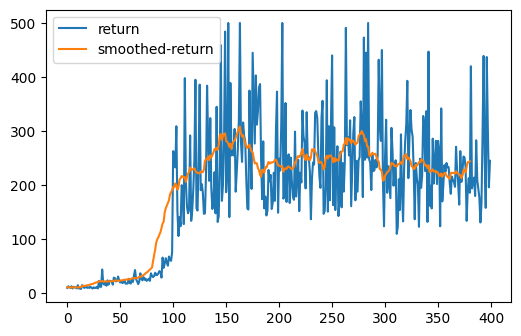

In [166]:
stats_np = np.asarray(stats)
losses_np = np.asarray(losses)
fig=plt.figure(figsize=(6,3.8))
plt.plot(stats_np[:,1], label="return")
plt.plot(running_mean(stats_np[:,1],20), label="smoothed-return")
plt.legend()

In [14]:
#fig.savefig(f"DQN_{env_name}_training_w_target_{use_target}-update-{target_update}.pdf")

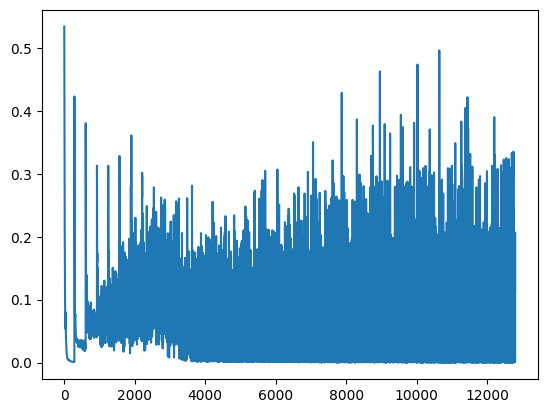

In [167]:
plt.figure()
plt.plot(losses_np)

In [54]:
q_agent.buffer.size

22014

### Using RND

In [207]:
use_target = True
target_update = 20
q_rnd_agent = DQNRNDAgent(o_space, ac_space, discount=0.95, eps=0.2, 
                   use_target_net=use_target, update_target_every= target_update)

In [208]:
stats = []
stats_intrinsic = []
losses = []

In [209]:
# with intrinsic rewards
max_episodes=600
max_steps=500 
for i in range(max_episodes):
    # print("Starting a new episode")    
    total_reward = 0
    total_intrinsic_reward = 0
    list_rew_i = []
    ob, _info = env.reset()
    for t in range(max_steps):
        done = False        
        a = q_rnd_agent.act(ob)
        (ob_new, reward, done, trunc, _info) = env.step(a)
        total_reward+= reward
        # get intrinsic rewards
        reward_i = q_rnd_agent.rnd.intrinsic_reward(torch.from_numpy(ob)).detach().clamp(-1.0, 1.0).item()
        list_rew_i.append(reward_i)
        
        # find combined reward
        if t==0:
            combined_reward = reward + reward_i
            total_intrinsic_reward+= reward_i
        elif t>0:
            # normalise intrinsic rewards by running std
            # random = np.random.rand() * 10 # for control with random intrinsic reward
            reward_i_norm = reward_i/np.std(list_rew_i) # normalised intrinsic reward
            combined_reward = reward + reward_i
            total_intrinsic_reward+= reward_i
        q_rnd_agent.store_transition((ob, a, combined_reward, ob_new, done))            
        ob=ob_new        
        if done: break   
    losses.extend(q_rnd_agent.train(32))
    stats.append([i,total_reward,t+1])
    stats_intrinsic.append([i,total_intrinsic_reward,t+1])
    
    if ((i-1)%20==0):
        print("{}: Done after {} steps. Reward: {}. Intrinsic Reward: {}".format(
            i, t+1, total_reward, total_intrinsic_reward))
        
    # if q_rnd_agent._eps > q_rnd_agent._config['eps_min']:
    #     q_rnd_agent._eps *= q_rnd_agent._config['eps_decay']    

1: Done after 9 steps. Reward: 9.0. Intrinsic Reward: 0.01462318969424814
21: Done after 63 steps. Reward: 63.0. Intrinsic Reward: 2.564639496617019
41: Done after 183 steps. Reward: 183.0. Intrinsic Reward: 14.173153191804886
61: Done after 91 steps. Reward: 91.0. Intrinsic Reward: 11.124547180719674
81: Done after 27 steps. Reward: 27.0. Intrinsic Reward: 1.428713208064437
101: Done after 55 steps. Reward: 55.0. Intrinsic Reward: 7.37335192784667
121: Done after 23 steps. Reward: 23.0. Intrinsic Reward: 2.0284930281341076
141: Done after 31 steps. Reward: 31.0. Intrinsic Reward: 2.2969416658233968
161: Done after 76 steps. Reward: 76.0. Intrinsic Reward: 13.390902767889202
181: Done after 31 steps. Reward: 31.0. Intrinsic Reward: 5.585717927664518
201: Done after 57 steps. Reward: 57.0. Intrinsic Reward: 9.089486272074282
221: Done after 45 steps. Reward: 45.0. Intrinsic Reward: 15.305410161614418
241: Done after 149 steps. Reward: 149.0. Intrinsic Reward: 16.545636992901564
261: Don

/var/folders/r5/35ml8bds4xgg92vk489jvb0r0007ds/T/ipykernel_67744/1161039631.py:26: RuntimeWarning: divide by zero encountered in scalar divide
  reward_i_norm = reward_i/np.std(list_rew_i) # normalised intrinsic reward


281: Done after 210 steps. Reward: 210.0. Intrinsic Reward: 73.33899453564663
301: Done after 500 steps. Reward: 500.0. Intrinsic Reward: 161.57848728168756
321: Done after 301 steps. Reward: 301.0. Intrinsic Reward: 28.020629176608054
341: Done after 276 steps. Reward: 276.0. Intrinsic Reward: 48.11709074303508
361: Done after 203 steps. Reward: 203.0. Intrinsic Reward: 15.582279630703852
381: Done after 254 steps. Reward: 254.0. Intrinsic Reward: 47.39916181424633


KeyboardInterrupt: 

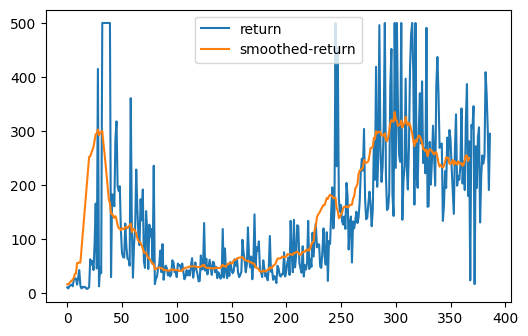

In [210]:
stats_np = np.asarray(stats)
stats_intrinsic_np = np.asarray(stats_intrinsic)
losses_np = np.asarray(losses)
fig=plt.figure(figsize=(6,3.8))
plt.plot(stats_np[:,1], label="return")
plt.plot(running_mean(stats_np[:,1],20), label="smoothed-return")
plt.legend()

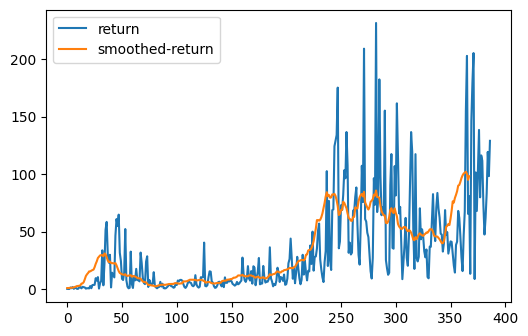

In [211]:
#stats_intrinsic_new = stats_intrinsic_np[np.where(stats_intrinsic_np[:, 1]<5000)[0], :]
fig=plt.figure(figsize=(6,3.8))
clipped = np.clip(stats_intrinsic_np[:,1], 0, 5000)
plt.plot(clipped, label="return")
plt.plot(running_mean(clipped,20), label="smoothed-return")
plt.legend()

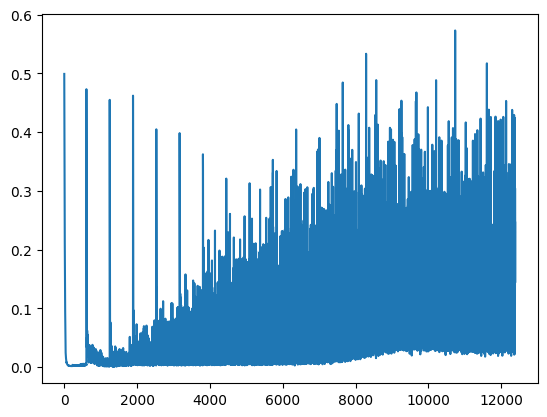

In [212]:
plt.figure()
losses_new = losses_np[np.where(losses_np<100)[0]]
plt.plot(np.clip(losses_np, 0, 10))

## Evaluate (without exploration)

### Without RND

In [174]:
env_eval = gym.make(env_name, render_mode="human")
if isinstance(env.action_space, spaces.Box):
    env_eval = DiscreteActionWrapper(env_eval,5)

In [175]:
test_stats = []
episodes=10
env_ = env    # without rendering
env_ = env_eval # with rendering

for i in range(episodes):
    total_reward = 0
    ob, _info = env_.reset()
    for t in range(max_steps):
        done = False        
        a = q_agent.act(ob, eps=0.0)
        (ob_new, reward, done, trunc, _info) = env_.step(a)
        total_reward+= reward
        ob=ob_new        
        if done: break    
    test_stats.append([i,total_reward,t+1])     
env.close()

In [176]:
test_stats_np = np.array(test_stats)
print(np.mean(test_stats_np[:,1]), "+-", np.std(test_stats_np[:,1]))

184.9 +- 9.761659694949419


### With RND

In [213]:
env_eval = gym.make(env_name, render_mode="human")
if isinstance(env.action_space, spaces.Box):
    env_eval = DiscreteActionWrapper(env_eval,5)

In [214]:
test_stats = []
episodes=50
env_ = env    # without rendering
#env_ = env_eval # with rendering

for i in range(episodes):
    total_reward = 0
    ob, _info = env_.reset()
    for t in range(max_steps):
        done = False        
        a = q_rnd_agent.act(ob, eps=0.0)
        (ob_new, reward, done, trunc, _info) = env_.step(a)
        total_reward+= reward
        ob=ob_new        
        if done: break    
    test_stats.append([i,total_reward,t+1])     
env.close()   

In [215]:
test_stats_np = np.array(test_stats)
print("Mean test reward {} +/- std {}".format(np.mean(test_stats_np[:,1]), np.std(test_stats_np[:,1])))

Mean test reward 237.62 +/- std 8.175304275682954
